In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Check columns
Station.__table__.columns.values()

[Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<station>),
 Column('name', TEXT(), table=<station>),
 Column('latitude', FLOAT(), table=<station>),
 Column('longitude', FLOAT(), table=<station>),
 Column('elevation', FLOAT(), table=<station>)]

In [11]:
Measurement.__table__.columns.values()

[Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<measurement>),
 Column('date', TEXT(), table=<measurement>),
 Column('prcp', FLOAT(), table=<measurement>),
 Column('tobs', FLOAT(), table=<measurement>)]

In [12]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

# Exploratory Climate Analysis

In [14]:
# Get the latest date from measurement
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

#split it to year, month and date
for date in last_date:
    split_last_date=date.split('-')
split_last_date

['2017', '08', '23']

In [15]:
# Calculate the date 1 year ago from the last data point in the database
last_year=int(split_last_date[0])
last_month=int(split_last_date[1])
last_day=int(split_last_date[2])
query_date = dt.date(last_year, last_month, last_day) - dt.timedelta(days=365)

print(query_date)

2016-08-23


In [16]:
# Perform a query to retrieve the data and precipitation scores
year_prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date).all()

In [17]:
# Save the query results as a Pandas DataFrame 
year_prcp_df = pd.DataFrame(year_prcp, columns=['date', 'prcp'])
# Clean the data
year_prcp_df = year_prcp_df.dropna(how="any")
# set the index to the date column
year_prcp_df.set_index('date',inplace=True)
# Sort the dataframe by date
year_prcp_df.sort_values("date")

year_prcp_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


## Precipitation Analysis

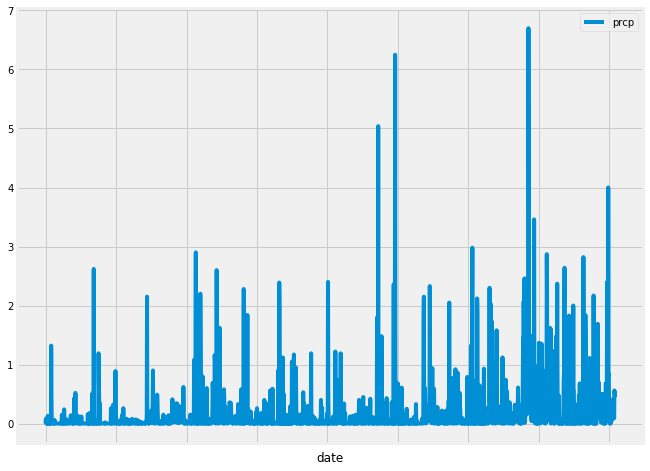

In [18]:
year_prcp_df.plot(figsize=(10,8))
plt.show()

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
year_prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [20]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(Measurement.station).\
    group_by(Measurement.station).count()        
print(total_stations)

9


In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
obs = [Measurement.station, func.count(Measurement.station)]
active_stations = session.query(*obs).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

top_station = (session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first())[0]

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
tem = [Measurement.station,
       func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]

stat_top_station = session.query(*tem).\
    filter(Measurement.station==top_station).all()
   
stat_top_station

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [23]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tem_top_station = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station==top_station).\
    filter(Measurement.date >= query_date).all()

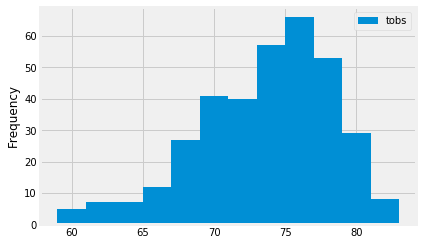

In [24]:
tem_top_station_df = pd.DataFrame(tem_top_station,columns=['date','tobs'])
tem_top_station_df.plot.hist(bins=12)
plt.show()